Toy Model of Coaxial Geothermal - Bob.Metcalfe@UTexas.edu - DRAFT 6/18/20

Playing with toy computer models is a great way to innovate. For example, I used toy models to invent Ethernet in 1973. Writing short codes to simulate various local-area network archectures led me to discover that there were good and bad system states. Ignoring details, my models found convergences and oscillations similar to those later experienced in real networks. I explored novel mechanisms for maintaining network stability and efficiency. 

Then we built the networks. Then we made them industry standards. Then we grew a company (3Com, now HP) to develop, manufacture, market, sell, and support them at scale. 

Many more sophisicated mathematical and computer models followed my toy first drafts. Ethernet evolved into the Internet's IEEE standard plumbing, with billions of Ethernet ports shipping every year, billions, especially if you let me count Wireless Ethernet AKA Wi-Fi. All starting with toy models.

So here I invite you to consider and perhaps play with a toy model of geothermal wells. Professor Eric van Oort and other colleagues have much better models and will soon peer-review them. This toy model is merely a blog post. We need to get more thermodynamics into the models.

Many modellers will tell you they learn more from building models than from numerical results.

My goal participating in http://TexasGEO.org is ... to solve energy once and for all -- cheap, clean, abundant, ubiquitous, safe... We aim to do this with deep closed-loop baseload geothermal electric power. There's plenty of heat in the Earth, billions of years worth. The trick is to harvest the heat econmically. We are now aiming to drill down ~10km into ~350C granite, bringing ~150C back to the surface for economic conversion into electricity. Expect these goals to evolve. 

You are reading a Jupyter Python notebook containing, soon, an editable and executable toy geothermal well model. You are invited to review, run, modify, and extend the model(s).

https://github.com/BobMetcalfe/GEO/blob/master/CoaxGEO.ipynb 

Since a major cost of geothermal wells is drilling, I thought I'd start with as little drilling as possible: one drilled hole with two concentric pipes. It's just a coincidence that the first Ethernet in 1973 used, yes, coaxial cable. To start, we'll send a working fluid, say water, down the outer pipe to be heated by surrounding granite. Then we'll bring the hot water back to the surface up the inner pipe, hopefullhy hot enough to be efficiently converted to electricity. 

The following Python code sketches models of various geothermal wells: 
    Simple Coaxial Well
    Partially Insulated Well
    Twistedm Pipe Well
    Horizontal Segment Well (not yet)
    Pulsed (not yet)
    U-Shaped Well (not yet)
    ...
    
The basic model is a PipeString, a list of pipes concatenated to form a closed-loop well. Each pipe has (1) a depth, which determines the ambient rock temperature, (2) an outer pipe, and (3) an inner pipe, each full of water at varying temperatures. So each pipe has three temperatures: ambient, outer, inner (AOI). Initially we assume cold water starts down the outer pipe and comes back up hot via the inner pipe. The pipes gain and lose heat with one another and ambient from surrounding rock. 

The model simulates water circulating through these pipes in a series of iterations, each iteration including an AOI temperature update to the contents of each pipe and a fluid flow through the pipes, one pipe per iteration. 

The goal is to send water down the PipeString and bring it back up hot enough to harvest heat to produce electricity.

Model initialization preparing for variousd well simulations. 

In [23]:
### Run initializatin code here before any simulations
# Here we bring in some Python programming resources.
import os
import sys
import math
import copy
import numpy as np
from matplotlib import pyplot as plt

# Here are important variables to be global. Not all are used yet.
global NumberOfIterations, NumberOfPipes, LengthOfPipe, PipeString
global DepthOfWell, BottomTemperature, TopTemperature, LoopTime
global History
global JoulesPerIteration, plotJoulesPerIteration
global plotBottomAmbient, plotTopAmbient, plotWellBottom, plotWellTop
global plotIterations
global EarthSurfaceTemperature, EarthTemperatureGradient
global HeatExchangeThreshold
global RockDensity, RockSpecificHeat, RockThermalConductivity
global FluidDensity, FluidSpecificHeat, FluidThermalConductivity

# Here is code for commenting orally and with text on simulation progress.
SpeakingOn = True # Turn audible simulation event announcements on or off. Always print.
def say(s): 
    if SpeakingOn: 
        os.system('say ' + s)
        print(s)
say("Toy Geothermal Model")
say("Please run this inialization before each simulation run.")

# Here we bring in some physical parameters of planet Earth.
# Note we sometimes show the units in brackets, like ""[C/m]"" for degrees Celsius per meter.
EarthSurfaceTemperature = 15.0 # [C] Varies.
EarthTemperatureGradient = 0.025 # [C/m] Varies.

# Ambient temperature in degrees Celsius at depth in meters
def AmbientTemperature(depth): # [C]
    return EarthSurfaceTemperature + (depth * EarthTemperatureGradient)

HeatExchangeThreshold = 150.0 # [C] Only heat at temps above this can be harvested

# Rock is ~granite
RockDensity = GraniteDensity = 2750000.0 # [g/m3]
RockSpecificHeat = GraniteSpecificHeat = 0.790 # [J/gC]
RockThermalConductivity = GraniteThermalConductivity = 2.62 # [W/mC]

# Working fluid is liquid water, ignore for now that water will turn to steam and go supercritical
FluidDensity = WaterDensity = 997000.0 # [g/m3]
FluidSpecificHeat = WaterSpecificHeat = 4.186 # [J/gC]
FluidThermalConductivity = WaterThermalConductivity = 0.6 # [W/mC]

# Here we specify the coaxial pipes with which we are going to drill
# Volume of inner and outer pipes is equal for now
NumberOfPipes = 100 # [n] 
LengthOfPipe = 10.0 # [m]
DepthOfWell = NumberOfPipes * LengthOfPipe # [m] Assumes we are drilling straight down, vertical well
BottomTemperature = AmbientTemperature(DepthOfWell)
TopTemperature = AmbientTemperature(0)
if (BottomTemperature < HeatExchangeThreshold):
    say("This well is for sure not be deep enough to produce any energy. But drill we must.") 

# AOI: inner pipe has an inner radius, outer pipe has a larger radius to keep up and down same volume.
InnerRadius = 0.5 # [m]
OuterRadius = InnerRadius * math.sqrt(2) # [m] Outer volume is net of inner volume inside it.

pi = math.pi
InnerArea = (2 * pi * InnerRadius) * LengthOfPipe # [m2 = square meters]
OuterArea = (2 * pi * OuterRadius) * LengthOfPipe # [m2]
InnerVolume = (pi * InnerRadius ** 2) * LengthOfPipe # [m3 = cubic meters]
OuterVolume = ((pi * OuterRadius ** 2) * LengthOfPipe) - InnerVolume # [m3] Outer volume is net of inner.
InnerMass = InnerVolume * FluidDensity # [g]
OuterMass = OuterVolume * FluidDensity # [g]

# Check to be sure inner and outer pipe volumes are equal (for now)
if round(InnerVolume,4) != round(OuterVolume,4): 
    say("Inner & outer pipe volumnes not equal.") 
    sys.exit(1)
    
say("Toy Geothermal Model initialization complete, thank you.")

global initialized
initialized = True

def simulationStart(titlestring): 
    say("Starting simulation of " + titlestring)
    
    global initialized
    print("Testing here if the model has been initialized, true or false (error).")
    print(initialized)
    del initialized


Toy Geothermal Model
Please run this inialization before each simulation run.
Toy Geothermal Model initialization complete, thank you.


Simple Coaxial Well

Starting simulation of Simple Coaxial Well
Testing here if the model has been initialized, true or false (error).
True
Start Partially Insulated Well Simulation: 100 iterations.
Drill baby drill. 1000 pipes to 10000 meters.
Surface: 15 Celsius, Bottom: 265 Celsius.
Total 'joules' produced are 0


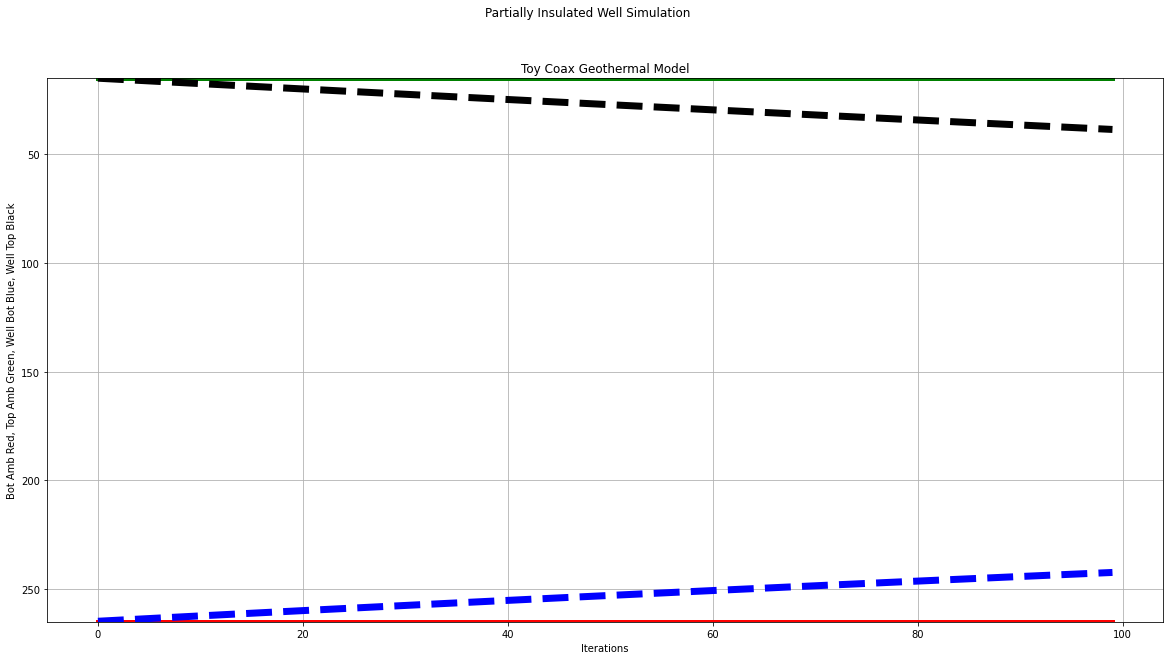

Completed Partially Insulated Well Simulation


In [24]:
simulationStart("Simple Coaxial Well")

NumberOfIterations = 100 

say("Start " + titlestring + ": " + str(NumberOfIterations) + " iterations.")

##########

# Drill straight down by concatenating pipes in a pipe string
PipeString = [] # Starts null, pipes appended at their depth's ambient temperature

# This intialization is repeated later for each model, so maybe delete this one
# i is index of pipe in PipeString, from 0 to NumberOfPipes-1
for i in range(NumberOfPipes):
    depth = i * LengthOfPipe
    ambienttemp = AmbientTemperature(depth)
    # fluid goes down outer pipe and up the inner pipe
    # Need to find out if deep coipies arer needed here.

    pipe = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
    
    PipeString.append(pipe) # Drill baby, drill
    
    # Completion of well at the surface. Bottom pipe is assumed to connect down pipe to up pipe.
IterationTime = 10 # [s] # Each iteration takes time to pump contents of one pipe.
PumpSpeed = InnerVolume/IterationTime # [m3/s]
LoopTime = 2 * (IterationTime * NumberOfPipes)
    
say("Drill baby drill. " + str(NumberOfPipes) + " pipes to " + str(int(DepthOfWell)) + " meters.")
say("Surface: " + str(int(TopTemperature)) + " Celsius, Bottom: " + str(int(BottomTemperature)) + " Celsius.")

##########

def Initialize(): # Get ready to run on exisitng well pipes
    
    global NumberOfPipes, PipeString, LengthOfPipe
    global History
    global plotJoulesPerIteration, JoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global plotIterations, iteration

    History = [] # This could be huge, when used, collects all pipes at all iterations.
    JoulesPerIteration = 0
    plotJoulesPerIteration = []
    plotBottomAmbient = []
    plotTopAmbient = []
    plotWellBottom = []
    plotWellTop = []
    plotIterations = []

    # i is index of pipe in PipeString, from 0 to NumberOfPipes-1, init with ambient at depth
    for i in range(NumberOfPipes):
        depth = i * LengthOfPipe
        ambienttemp = AmbientTemperature(depth)
        # fluid goes down outer pipe and up the inner pipe
        PipeString[i] = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
        
##########

# This AOI may look like thermodynamics, but it is not.
# Heat is exchanged as water passes through this one pipe (inner anbd outer)
# Current model of "heat" uses temperatures, needs thermo updating

def AOI():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(pipe["depth"])
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + (998 * OtempStart) + ItempStart) / 1000.0
        ItempEnd = (OtempStart + (999 * ItempStart)) / 1000.0
        
        pipe["outertemp"] = OtempEnd
        pipe["innertemp"] = ItempEnd
        
        PipeString[j] = copy.deepcopy(pipe)
        
##########

# pump fluid around PipeString, down outer, up inner chamber
# AOL = Ambient, Outer (down), Inner (up)

def Flow(): 
    
    global History
    global PipeString, NumberOfPipes, LengthOfPipe
    global JoulesPerIteration, plotJoulesPerIteration, TopTemp, UseableTemp, HeatExchangeThreshold
    global OuterMass, FluidSpecificheat
    global plotBottomAmbient, plotTopAmbient
    global plotWellBottom, plotWellTop
    global plotIterations, iteration
    global BottomTemperature, TopTemperature
    global FluidSpecificHeat

    NOP = len(PipeString) # Number Of Pipes
    if (NOP != NumberOfPipes):
        print("Number of pipes mismatch",NumberOfPipes,NOP)
        sys.exit(0)
        
    # Collect history for plotting at the end
    # History.append(copy.deepcopy(PipeString)) # This is big: iterations X pipes X temperatures
    
    plotJoulesPerIteration.append(JoulesPerIteration)
    plotBottomAmbient.append(AmbientTemperature(len(PipeString) * LengthOfPipe))
    plotTopAmbient.append(AmbientTemperature(0))
    plotWellBottom.append(PipeString[-1]["outertemp"]) # Temperature of working fluid at bottom of well
    plotWellTop.append(PipeString[0]["innertemp"]) # Temperature of working fluid at top of the well
    plotIterations.append(iteration)


    # Be sure circulation of working fluid does not lose any fluid, add all up
    checksum = 0
    for p in PipeString:
        checksum += (round(p["outertemp"],3) + round(p["innertemp"],3))
        
    ################ Start moving fluid
    
    saved0i = PipeString[0]["innertemp"] # Temp hold on temperature about to be overwritten, 0th inner, top inner

    # Move fluid up inner pipe
    for n in range(NOP-1):
        PipeString[n]["innertemp"] = PipeString[n+1]["innertemp"] # fluid moving up

    # Turn around at bottom of well, from down outer to up inner
    PipeString[NOP-1]["innertemp"] = PipeString[NOP-1]["outertemp"]

    # Move fluid down outer pipe
    for n in range(NOP-1,0,-1):
        PipeString[n]["outertemp"] = PipeString[n-1]["outertemp"]

    PipeString[0]["outertemp"] = saved0i
    
    #Check that working fluid is conserved
    check = 0
    for p in PipeString:
        check += (round(p["outertemp"],3) + round(p["innertemp"],3))
    if (round(check,3) != round(checksum,3)):
        print("Flow pumping is broken.")
        sys.exit(0)
        
    ################# Harvest all heat above threshold at returning top
    
    TopTemp = PipeString[0]["outertemp"]
    if (TopTemp > HeatExchangeThreshold):
        UseableTemp = TopTemp - HeatExchangeThreshold
        JoulesPerIteration = OuterMass * FluidSpecificHeat * UseableTemp # Needs thermo
        PipeString[0]["outertemp"] = HeatExchangeThreshold
        
##########

# Plot temperatures et al as function of time (iterations)
def IterationPlot(suptitletext=''): 
    
    global plotIterations
    
    global plotJoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global BottomTemperature, TopTemperature
    
    t = 0.0
    for j in range(len(plotJoulesPerIteration)):
        t += plotJoulesPerIteration[j]
    print("Total 'joules' produced are",f"{round(t):,}")
    
    f = plt.figure(figsize=(20,10))
    plt.plot(plotIterations, plotBottomAmbient, color='red', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotTopAmbient, color='green', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotWellBottom, color='blue', linestyle='dashed', linewidth = 7)
    plt.plot(plotIterations, plotWellTop, color='black', linestyle='dashed', linewidth = 7)

    plt.xlabel('Iterations')
    plt.ylabel('Bot Amb Red, Top Amb Green, Well Bot Blue, Well Top Black')
    plt.title("Toy Coax Geothermal Model")
    plt.suptitle(suptitletext)
    plt.grid(True)
    plt.ylim(BottomTemperature,TopTemperature)
    plt.show()
    
##########

Initialize()

for iteration in range(NumberOfIterations): # iteration on thermo update 
    AOI() # Update inner and outer temps from AOI
    Flow() # Move working fluid one pipe along, up, down, and around
    if ((iteration%1000) == 999):
            thousands = str((iteration+1)//1000)
            say("Iteration " + thousands + " thousand")  

IterationPlot(titlestring) 
say("Completed " + titlestring)

Partially Insulated (top half of upward pipe)

Testing here if the model has been initialized, true or false (error).
True
Drill baby drill. 1000 pipes to 10000 meters.
Surface: 15 Celsius, Bottom: 265 Celsius.
Starting Partially Insulated Well Simulation with simulation iterations of 100
Total 'joules' produced are 0


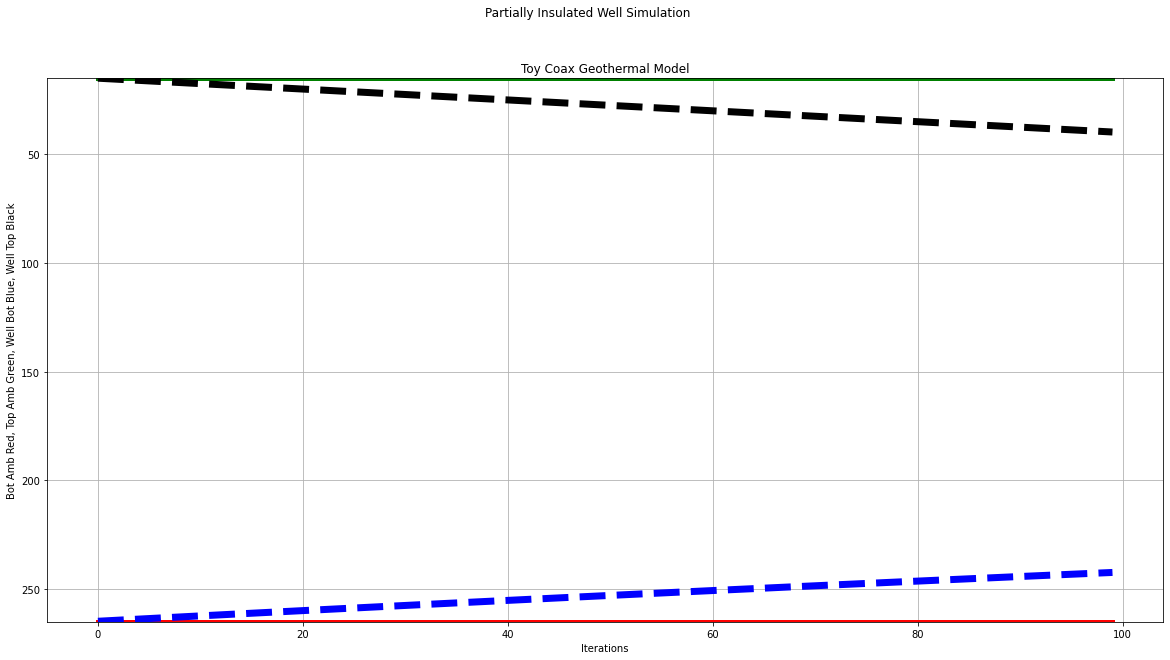

Completed Partially Insulated Well Simulation


In [22]:
# This version of AOI heat exchange assumes top of inner/upward pipe is insulated perfectly
titlestring = "Partially Insulated Well Simulation"

global initialized
print("Testing here if the model has been initialized, true or false (error).")
print(initialized)
del initialized

Transition = int(NumberOfPipes / 2.0)

##########

# Drill straight down by concatenating pipes in a pipe string
PipeString = [] # Starts null, pipes appended at their depth's ambient temperature

# This intialization is repeated later for each model, so maybe delete this one
# i is index of pipe in PipeString, from 0 to NumberOfPipes-1
for i in range(NumberOfPipes):
    depth = i * LengthOfPipe
    ambienttemp = AmbientTemperature(depth)
    # fluid goes down outer pipe and up the inner pipe
    # Need to find out if deep copies arer needed here.

    pipe = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
    
    PipeString.append(pipe) # Drill baby, drill
    
    # Completion of well at the surface. Bottom pipe is assumed to connect down pipe to up pipe.
IterationTime = 10 # [s] # Each iteration takes time to pump contents of one pipe.
PumpSpeed = InnerVolume/IterationTime # [m3/s]
LoopTime = 2 * (IterationTime * NumberOfPipes)
    
say("Drill baby drill. " + str(NumberOfPipes) + " pipes to " + str(int(DepthOfWell)) + " meters.")
say("Surface: " + str(int(TopTemperature)) + " Celsius, Bottom: " + str(int(BottomTemperature)) + " Celsius.")

#########

def Initialize(): # Get ready to run on exisitng well pipes
    
    global NumberOfPipes, PipeString, LengthOfPipe
    global History
    global plotJoulesPerIteration, JoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global plotIterations, iteration

    History = [] # This could be huge, when used, collects all pipes at all iterations.
    JoulesPerIteration = 0
    plotJoulesPerIteration = []
    plotBottomAmbient = []
    plotTopAmbient = []
    plotWellBottom = []
    plotWellTop = []
    plotIterations = []

    # i is index of pipe in PipeString, from 0 to NumberOfPipes-1, init with ambient at depth
    for i in range(NumberOfPipes):
        depth = i * LengthOfPipe
        ambienttemp = AmbientTemperature(depth)
        # fluid goes down outer pipe and up the inner pipe
        PipeString[i] = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})

# pump fluid around PipeString, down outer, up inner chamber
# AOL = Ambient, Outer (down), Inner (up)

##########

def AOIINS():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(j * LengthOfPipe)
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + (998 * OtempStart) + ItempStart) / 1000.0
        ItempEnd = (OtempStart + (999 * ItempStart)) / 1000.0
        
        pipe["outertemp"] = OtempEnd
        if (j > Transition):
            pipe["innertemp"] = ItempEnd # Top of up pipe insulated, no lost heat (ha!)
        
        PipeString[j] = copy.deepcopy(pipe)
        
###########

def Flow(): 
    
    global History
    global PipeString, NumberOfPipes, LengthOfPipe
    global JoulesPerIteration, plotJoulesPerIteration, TopTemp, UseableTemp, HeatExchangeThreshold
    global OuterMass, FluidSpecificheat
    global plotBottomAmbient, plotTopAmbient
    global plotWellBottom, plotWellTop
    global plotIterations, iteration
    global BottomTemperature, TopTemperature
    global FluidSpecificHeat

    NOP = len(PipeString) # Number Of Pipes
    if (NOP != NumberOfPipes):
        print("Number of pipes mismatch",NumberOfPipes,NOP)
        sys.exit(0)
        
    # Collect history for plotting at the end
    # History.append(copy.deepcopy(PipeString)) # This is big: iterations X pipes X temperatures
    
    plotJoulesPerIteration.append(JoulesPerIteration)
    plotBottomAmbient.append(AmbientTemperature(len(PipeString) * LengthOfPipe))
    plotTopAmbient.append(AmbientTemperature(0))
    plotWellBottom.append(PipeString[-1]["outertemp"]) # Temperature of working fluid at bottom of well
    plotWellTop.append(PipeString[0]["innertemp"]) # Temperature of working fluid at top of the well
    plotIterations.append(iteration)


    # Be sure circulation of working fluid does not lose any fluid, add all up
    checksum = 0
    for p in PipeString:
        checksum += (round(p["outertemp"],3) + round(p["innertemp"],3))
        
    ################ Start moving fluid
    
    saved0i = PipeString[0]["innertemp"] # Temp hold on temperature about to be overwritten, 0th inner, top inner

    # Move fluid up inner pipe
    for n in range(NOP-1):
        PipeString[n]["innertemp"] = PipeString[n+1]["innertemp"] # fluid moving up

    # Turn around at bottom of well, from down outer to up inner
    PipeString[NOP-1]["innertemp"] = PipeString[NOP-1]["outertemp"]

    # Move fluid down outer pipe
    for n in range(NOP-1,0,-1):
        PipeString[n]["outertemp"] = PipeString[n-1]["outertemp"]

    PipeString[0]["outertemp"] = saved0i
    
    #Check that working fluid is conserved
    check = 0
    for p in PipeString:
        check += (round(p["outertemp"],3) + round(p["innertemp"],3))
    if (round(check,3) != round(checksum,3)):
        print("Flow pumping is broken.")
        sys.exit(0)
        
    ################# Harvest all heat above threshold at returning top
    
    TopTemp = PipeString[0]["outertemp"]
    if (TopTemp > HeatExchangeThreshold):
        UseableTemp = TopTemp - HeatExchangeThreshold
        JoulesPerIteration = OuterMass * FluidSpecificHeat * UseableTemp # Needs thermo
        PipeString[0]["outertemp"] = HeatExchangeThreshold
        
##########

# Plot temperatures et al as function of time (iterations)
def IterationPlot(suptitletext=''): 
    
    global plotIterations
    
    global plotJoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global BottomTemperature, TopTemperature
    
    t = 0.0
    for j in range(len(plotJoulesPerIteration)):
        t += plotJoulesPerIteration[j]
    print("Total 'joules' produced are",f"{round(t):,}")
    
    f = plt.figure(figsize=(20,10))
    plt.plot(plotIterations, plotBottomAmbient, color='red', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotTopAmbient, color='green', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotWellBottom, color='blue', linestyle='dashed', linewidth = 7)
    plt.plot(plotIterations, plotWellTop, color='black', linestyle='dashed', linewidth = 7)

    plt.xlabel('Iterations')
    plt.ylabel('Bot Amb Red, Top Amb Green, Well Bot Blue, Well Top Black')
    plt.title("Toy Coax Geothermal Model")
    plt.suptitle(suptitletext)
    plt.grid(True)
    plt.ylim(BottomTemperature,TopTemperature)
    plt.show()
    
##########

Initialize()

NumberOfIterations = 100

say("Starting " + titlestring + " with simulation iterations of " + str(NumberOfIterations))

for iteration in range(NumberOfIterations): # iteration on thermo update
    
    AOIINS() # Update inner and outer temps from AOI
    
    Flow() # Move working fluid one pipe along, up, down, and around 
    
    if ((iteration%1000) == 999):
        thousands = str((iteration+1)//1000)
        say("Iteration " + thousands + " thousand")
        
IterationPlot(titlestring)
say("Completed " + titlestring)

Twisted Pipe Insertion

Drill baby drill. 1000 pipes to 10000 meters.
Surface: 15 Celsius, Bottom: 265 Celsius.
Starting Twisted Pipe Insertion with 10000 iterations.
Iteration 1 thousand
Iteration 2 thousand
Iteration 3 thousand
Iteration 4 thousand
Iteration 5 thousand
Iteration 6 thousand
Iteration 7 thousand
Iteration 8 thousand
Iteration 9 thousand
Iteration 10 thousand
Total 'joules' produced are 218,375,683,189


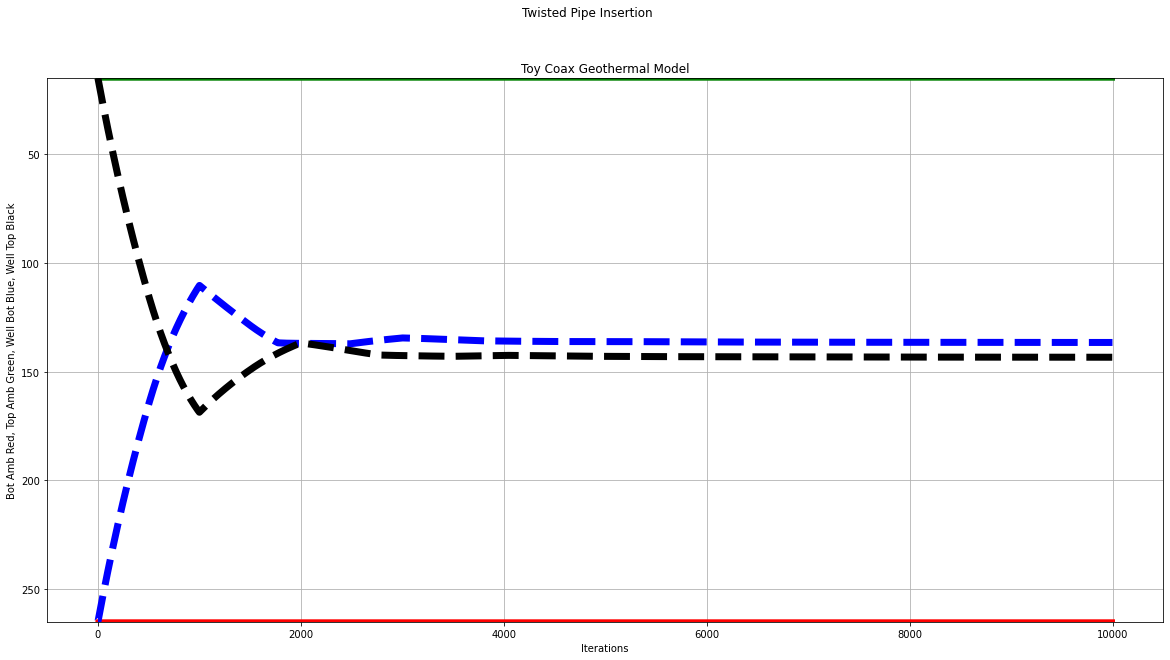

Completed Twisted Pipe Insertion


In [3]:
titlestring = "Twisted Pipe Insertion"

# This version of Flow assumes a twisted pipe is inserted half way down.
# The twist switches outer downward to inner, and inner upward to downward.

global initialized
print("Testing here if the model has been initialized, true or false (error).")
print(initialized)
del initialized
    
##########

# Drill straight down by concatenating pipes in a pipe string
PipeString = [] # Starts null, pipes appended at their depth's ambient temperature

# This intialization is repeated later for each model, so maybe delete this one
# i is index of pipe in PipeString, from 0 to NumberOfPipes-1
for i in range(NumberOfPipes):
    depth = i * LengthOfPipe
    ambienttemp = AmbientTemperature(depth)
    # fluid goes down outer pipe and up the inner pipe
    # Need to find out if deep coipies arer needed here.

    pipe = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
    
    PipeString.append(pipe) # Drill baby, drill
    
# Completion of well at the surface. Bottom pipe is assumed to connect down pipe to up pipe.
IterationTime = 10 # [s] # Each iteration takes time to pump contents of one pipe.
PumpSpeed = InnerVolume/IterationTime # [m3/s]
LoopTime = 2 * (IterationTime * NumberOfPipes)
    
say("Drill baby drill. " + str(NumberOfPipes) + " pipes to " + str(int(DepthOfWell)) + " meters.")
say("Surface: " + str(int(TopTemperature)) + " Celsius, Bottom: " + str(int(BottomTemperature)) + " Celsius.")

##########

def Initialize(): # Get ready to run on exisitng well pipes
    
    global NumberOfPipes, PipeString, LengthOfPipe
    global History
    global plotJoulesPerIteration, JoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global plotIterations, iteration

    History = [] # This could be huge, when used, collects all pipes at all iterations.
    JoulesPerIteration = 0
    plotJoulesPerIteration = []
    plotBottomAmbient = []
    plotTopAmbient = []
    plotWellBottom = []
    plotWellTop = []
    plotIterations = []
        
###########

# This AOI may look like thermodynamics, but it is not.
# Heat is exchanged as water passes through this one pipe (inner anbd outer)
# Current model of "heat" uses temperatures, needs thermo updating

def AOI():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(pipe["depth"])
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + (998 * OtempStart) + ItempStart) / 1000.0
        ItempEnd = (OtempStart + (999 * ItempStart)) / 1000.0
        
        pipe["outertemp"] = OtempEnd
        pipe["innertemp"] = ItempEnd
        
        PipeString[j] = copy.deepcopy(pipe)
        
##########

def TwistedFlow(): 
    
    global History
    global PipeString, NumberOfPipes, LengthOfPipe
    global JoulesPerIteration, plotJoulesPerIteration, TopTemp, UseableTemp, HeatExchangeThreshold
    global OuterMass, FluidSpecificheat
    global plotBottomAmbient, plotTopAmbient
    global plotWellBottom, plotWellTop
    global plotIterations, iteration
    global BottomTemperature, TopTemperature
    global FluidSpecificHeat

    NOP = len(PipeString) # Number Of Pipes
    if (NOP != NumberOfPipes):
        print("Number of pipes mismatch",NumberOfPipes,NOP)
        sys.exit(0)
        
    # Collect history for plotting at the end
    # History.append(copy.deepcopy(PipeString)) # This is big: iterations X pipes X temperatures
    
    plotJoulesPerIteration.append(JoulesPerIteration)
    plotBottomAmbient.append(AmbientTemperature(len(PipeString) * LengthOfPipe))
    plotTopAmbient.append(AmbientTemperature(0))
    plotWellBottom.append(PipeString[-1]["outertemp"]) # Temperature of working fluid at bottom of well
    plotWellTop.append(PipeString[0]["innertemp"]) # Temperature of working fluid at top of the well
    plotIterations.append(iteration)

    # Be sure circulation of working fluid does not lose any fluid, add all up
    checksum = 0
    for p in PipeString:
        checksum += (round(p["outertemp"],3) + round(p["innertemp"],3))
        
    # ---------------------------------
    
    # 1/4 flow downward outer
    savedto = PipeString[Transition]["outertemp"] # about to be overwritten
    for n in range(Transition,0,-1):
        PipeString[n]["outertemp"] = PipeString[n-1]["outertemp"]

    # 2/4 flow downward inner
    savedNOPm1i = PipeString[NOP-1]["innertemp"] # Temp hold, NOP-1 inner
    for n in range(NOP-1,Transition+1,-1):
        PipeString[n]["innertemp"] = PipeString[n-1]["innertemp"] # below Transition fluid moving down inner
    PipeString[Transition+1]["innertemp"] = savedto
   
    # 3/4 flow upward outer
    savedot1 = PipeString[Transition+1]["outertemp"]
    for n in range(Transition+1,NOP-1,1):
        PipeString[n]["outertemp"] = PipeString[n+1]["outertemp"]
    PipeString[NOP-1]["outertemp"] = savedNOPm1i # flow water from downward inner to upward outer
    
    # 4/4 flow upward inner
    saved0i = PipeString[0]["innertemp"]
    for n in range(0,Transition,1):
        PipeString[n]["innertemp"] = PipeString[n+1]["innertemp"] # above Transition fluid moving up inner
    PipeString[0]["outertemp"] = saved0i # turn fluid around at top, from inner up to outer down, done
    PipeString[Transition]["innertemp"] = savedot1
        
    # ---------------------------------
    
    #Check that working fluid is conserved
    check = 0
    for p in PipeString:
        check += (round(p["outertemp"],3) + round(p["innertemp"],3))
    if (round(check,3) != round(checksum,3)):
        print("Flow pumping is broken.")
        sys.exit(0)

    ################# Harvest all heat above threshold at returning top
    
    TopTemp = PipeString[0]["outertemp"]
    if (TopTemp > HeatExchangeThreshold):
        UseableTemp = TopTemp - HeatExchangeThreshold
        JoulesPerIteration = OuterMass * FluidSpecificHeat * UseableTemp # Needs thermo
        PipeString[0]["outertemp"] = HeatExchangeThreshold
        


# Plot temperatures et al as function of time (iterations)
def IterationPlot(suptitletext=''): 
    
    global plotIterations
    
    global plotJoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global BottomTemperature, TopTemperature
    
    t = 0.0
    for j in range(len(plotJoulesPerIteration)):
        t += plotJoulesPerIteration[j]
    print("Total 'joules' produced are",f"{round(t):,}")
    
    f = plt.figure(figsize=(20,10))
    plt.plot(plotIterations, plotBottomAmbient, color='red', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotTopAmbient, color='green', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotWellBottom, color='blue', linestyle='dashed', linewidth = 7)
    plt.plot(plotIterations, plotWellTop, color='black', linestyle='dashed', linewidth = 7)

    plt.xlabel('Iterations')
    plt.ylabel('Bot Amb Red, Top Amb Green, Well Bot Blue, Well Top Black')
    plt.title("Toy Coax Geothermal Model")
    plt.suptitle(suptitletext)
    plt.grid(True)
    plt.ylim(BottomTemperature,TopTemperature)
    plt.show()
    
##########

Initialize()

NumberOfIterations = 10000
say("Starting " + titlestring + " with " + str(NumberOfIterations) + " iterations.")

Transition = int(NumberOfPipes / 2.0)
if (Transition < 10):
    Saying ("Too few pipes for twisted transition.")
    sys.exit(0)

for iteration in range(NumberOfIterations): # iteration on thermo update
    
    AOI() # Update inner and outer temps from AOI
    
    TwistedFlow() # Move working fluid one pipe along, up, down, and around 
    
    if ((iteration%1000) == 999):
        thousands = str((iteration+1)//1000)
        say("Iteration " + thousands + " thousand")
    
IterationPlot(titlestring)

say("Completed " + titlestring)

Horizontal Leg

In [7]:
# Let the drilling begin, down and then horizontal
NumberOfVerticalPipes = 1000
NumberOfHorizontalPipes = 100
NumberOfPipes = NumberOfVerticalPipes + NumberOfHorizontalPipes

# Drill down by concatenating pipes in a pipe string
PipeString = [] # Starts null, pipes appended at their depth's ambient temperature

# This intialization is repeated later for each model, so maybe delete this one
# i is index of pipe in PipeString, from 0 to NumberOfPipes-1
for i in range(NumberOfVerticalPipes):
    depth = i * LengthOfPipe
    ambienttemp = AmbientTemperature(depth)
    # fluid goes down outer pipe and up the inner pipe
    # Need to find out if deep coipies are needed here.

    pipe = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
    
    PipeString.append(pipe) # Drill baby, drill
    
# depth and ambienttemp (from above) will now be constant for horizontal leg
    
for i in range(NumberOfHorizontalPipes):

    pipe = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
    
    PipeString.append(pipe) # Drill baby, drill
    
say("Drill baby drill. " + str(NumberOfPipes) + " pipes to " + str(int(depth)) + " meters.")
say("Horizontal leg of " + str(NumberOfHorizontalPipes) + " pipes.") 
say("Surface: " + str(int(TopTemperature)) + " Celsius, Bottom: " + str(int(ambienttemp)) + " Celsius.")

Drill baby drill. 1100 pipes to 9990 meters.
Horizontal leg of 100 pipes.
Surface: 15 Celsius, Bottom: 264 Celsius.


In [8]:
# Completion of well at the surface. Bottom pipe is assumed to connect down pipe to up pipe.
IterationTime = 10 # [s] # Each iteration takes time to pump contents of one pipe.
PumpSpeed = InnerVolume/IterationTime # [m3/s]
LoopTime = 2 * (IterationTime * NumberOfPipes)

In [9]:
def Initialize(): # Get ready to run on exisitng well pipes
    
    global NumberOfPipes, PipeString, LengthOfPipe
    global History
    global plotJoulesPerIteration, JoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global plotIterations, iteration

    History = [] # This could be huge, when used, collects all pipes at all iterations.
    JoulesPerIteration = 0
    plotJoulesPerIteration = []
    plotBottomAmbient = []
    plotTopAmbient = []
    plotWellBottom = []
    plotWellTop = []
    plotIterations = []

    # i is index of pipe in PipeString, from 0 to NumberOfPipes-1, init with ambient at depth
    for i in range(NumberOfPipes):
        depth = i * LengthOfPipe
        ambienttemp = AmbientTemperature(depth)
        # fluid goes down outer pipe and up the inner pipe
        PipeString[i] = copy.deepcopy({"depth": depth,"innertemp": ambienttemp,"outertemp": ambienttemp})
        

In [10]:
# This AOI may look like thermodynamics, but it is not.
# Heat is exchanged as water passes through this one pipe (inner anbd outer)
# Current model of "heat" uses temperatures, needs thermo updating

def AOI():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(pipe["depth"])
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + (998 * OtempStart) + ItempStart) / 1000.0
        ItempEnd = (OtempStart + (999 * ItempStart)) / 1000.0
        
        pipe["outertemp"] = OtempEnd
        pipe["innertemp"] = ItempEnd
        
        PipeString[j] = copy.deepcopy(pipe)

In [11]:
# pump fluid around PipeString, down outer, up inner chamber
# AOL = Ambient, Outer (down), Inner (up)

def Flow(): 
    
    global History
    global PipeString, NumberOfPipes, LengthOfPipe
    global JoulesPerIteration, plotJoulesPerIteration, TopTemp, UseableTemp, HeatExchangeThreshold
    global OuterMass, FluidSpecificheat
    global plotBottomAmbient, plotTopAmbient
    global plotWellBottom, plotWellTop
    global plotIterations, iteration
    global BottomTemperature, TopTemperature
    global FluidSpecificHeat

    NOP = len(PipeString) # Number Of Pipes
    if (NOP != NumberOfPipes):
        print("Number of pipes mismatch",NumberOfPipes,NOP)
        sys.exit(0)
        
    # Collect history for plotting at the end
    # History.append(copy.deepcopy(PipeString)) # This is big: iterations X pipes X temperatures
    
    plotJoulesPerIteration.append(JoulesPerIteration)
    plotBottomAmbient.append(AmbientTemperature(len(PipeString) * LengthOfPipe))
    plotTopAmbient.append(AmbientTemperature(0))
    plotWellBottom.append(PipeString[-1]["outertemp"]) # Temperature of working fluid at bottom of well
    plotWellTop.append(PipeString[0]["innertemp"]) # Temperature of working fluid at top of the well
    plotIterations.append(iteration)

    # Be sure circulation of working fluid does not lose any fluid, add all up
    checksum = 0
    for p in PipeString:
        checksum += (round(p["outertemp"],3) + round(p["innertemp"],3))
        
    ################ Start moving fluid
    
    saved0i = PipeString[0]["innertemp"] # Temp hold on temperature about to be overwritten, 0th inner, top inner

    # Move fluid up inner pipe
    for n in range(NOP-1):
        PipeString[n]["innertemp"] = PipeString[n+1]["innertemp"] # fluid moving up

    # Turn around at bottom of well, from down outer to up inner
    PipeString[NOP-1]["innertemp"] = PipeString[NOP-1]["outertemp"]

    # Move fluid down outer pipe
    for n in range(NOP-1,0,-1):
        PipeString[n]["outertemp"] = PipeString[n-1]["outertemp"]

    PipeString[0]["outertemp"] = saved0i
    
    #Check that working fluid is conserved
    check = 0
    for p in PipeString:
        check += (round(p["outertemp"],3) + round(p["innertemp"],3))
    if (round(check,3) != round(checksum,3)):
        print("Flow pumping is broken.")
        sys.exit(0)

    ################# Harvest all heat above threshold at returning top
    
    TopTemp = PipeString[0]["outertemp"]
    if (TopTemp > HeatExchangeThreshold):
        UseableTemp = TopTemp - HeatExchangeThreshold
        JoulesPerIteration = OuterMass * FluidSpecificHeat * UseableTemp # Needs thermo
        PipeString[0]["outertemp"] = HeatExchangeThreshold


In [12]:
# Plot temperatures et al as function of time (iterations)
def IterationPlot(suptitletext=''): 
    
    global plotIterations
    
    global plotJoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    
    global BottomTemperature, TopTemperature
    
    t = 0.0
    for j in range(len(plotJoulesPerIteration)):
        t += plotJoulesPerIteration[j]
    print("Total 'joules' produced are",f"{round(t):,}")
    
    f = plt.figure(figsize=(20,10))
    plt.plot(plotIterations, plotBottomAmbient, color='red', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotTopAmbient, color='green', linestyle='solid', linewidth = 5)
    plt.plot(plotIterations, plotWellBottom, color='blue', linestyle='dashed', linewidth = 7)
    plt.plot(plotIterations, plotWellTop, color='black', linestyle='dashed', linewidth = 7)

    plt.xlabel('Iterations')
    plt.ylabel('Bot Amb Red, Top Amb Green, Well Bot Blue, Well Top Black') 
    plt.title("Toy Coax Geothermal Model")
    plt.suptitle(suptitletext)
    plt.grid(True)
    plt.ylim(BottomTemperature,TopTemperature)
    plt.show()
    

Start Simple Coaxial Well: 10000 iterations.
Elapsed real time for simulation: 27.78 hours.
Iteration 1 thousand
Iteration 2 thousand
Iteration 3 thousand
Iteration 4 thousand
Iteration 5 thousand
Iteration 6 thousand
Iteration 7 thousand
Iteration 8 thousand
Iteration 9 thousand
Iteration 10 thousand
Total 'joules' produced are 2,411,403,204,797


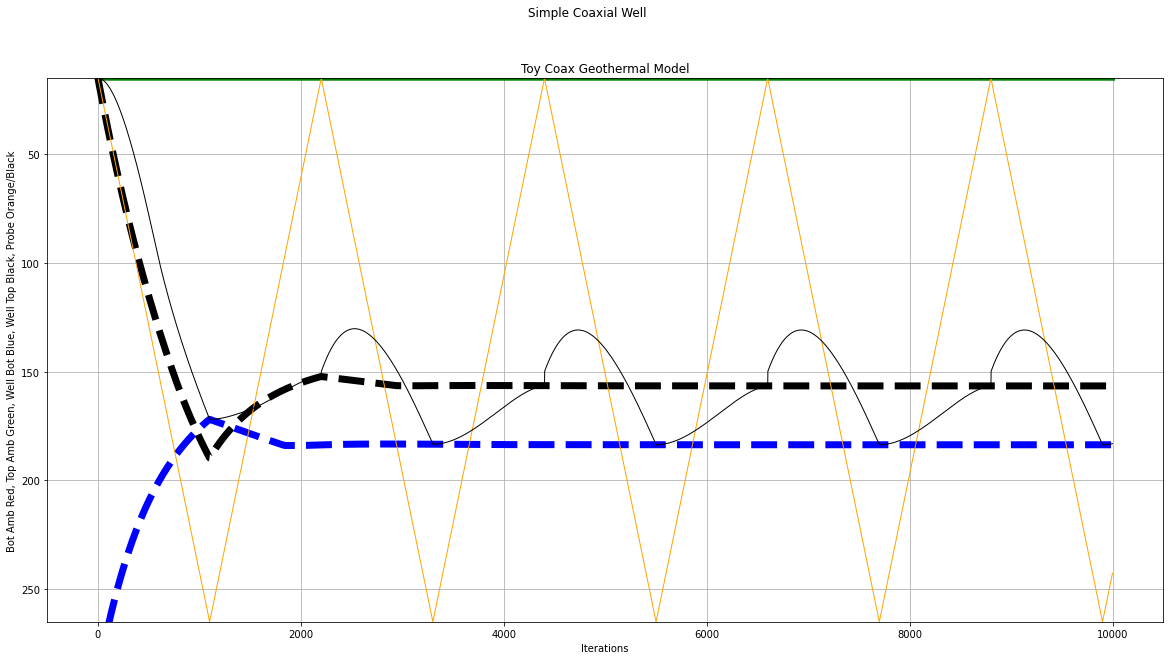

Completed Simple Coaxial Well


In [13]:
titlestring = "Simple Coaxial Well"

Initialize()

NumberOfIterations = 100 
SimulationHours = (NumberOfIterations * IterationTime) / 3600.0

say("Start " + titlestring + ": " + str(NumberOfIterations) + " iterations.")
say("Elapsed real time for simulation: " + str(round(SimulationHours,2)) + " hours.")

for iteration in range(NumberOfIterations): # iteration on thermo update 
    AOI() # Update inner and outer temps from AOI
    Flow() # Move working fluid one pipe along, up, down, and around
    if ((iteration%1000) == 999):
            thousands = str((iteration+1)//1000)
            say("Iteration " + thousands + " thousand")  

IterationPlot(titlestring) 
say("Completed " + titlestring)

Starting Horizontal Leg with 1000 iterations.
Iteration 1 thousand
Total 'joules' produced are 134,705,524,405


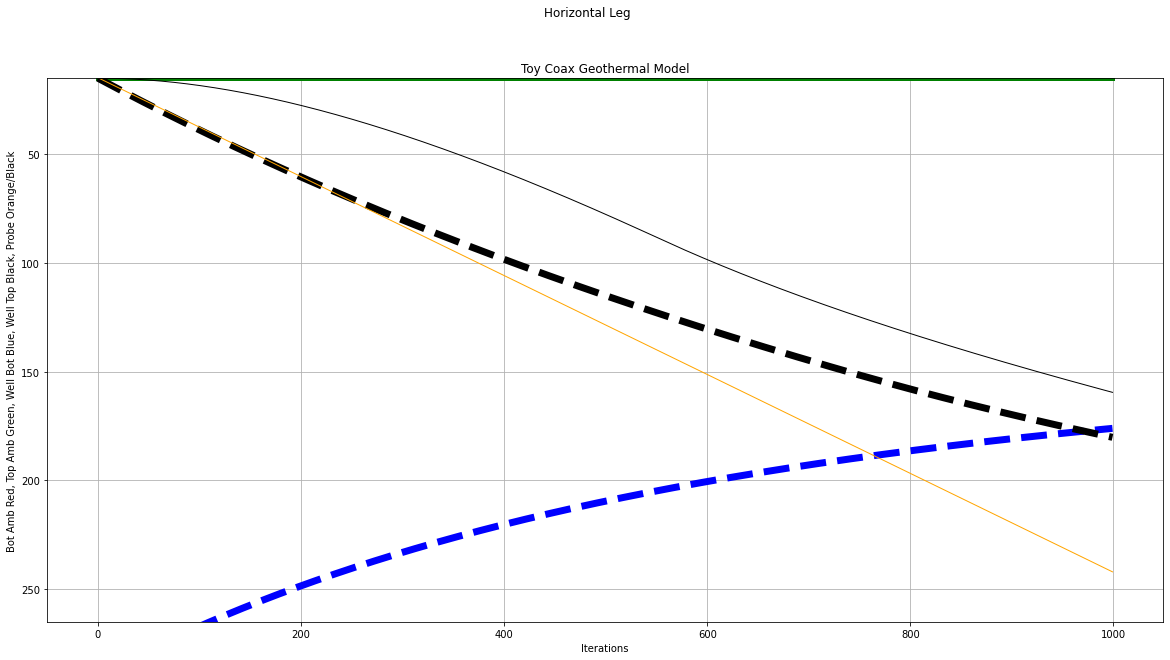

Completed Horizontal Leg


In [14]:
titlestring = "Horizontal Leg"

if Initialized == False: 
    say("Not initialized. Please do.")
    sys.exit(1)

Initialize()

NumberOfIterations = 1000
say("Starting " + titlestring + " with " + str(NumberOfIterations) + " iterations.")

for iteration in range(NumberOfIterations): # iteration on thermo update
    
    AOI() # Update inner and outer temps from AOI
    
    Flow() # Move working fluid one pipe along, up, down, and around 
    
    if ((iteration%1000) == 999):
        thousands = str((iteration+1)//1000)
        say("Iteration " + thousands + " thousand")
    
IterationPlot(titlestring)

say("Completed " + titlestring)

In [15]:
say("Toy Geothermal Model Completed. Have a nice day.")


Toy Geothermal Model Completed. Have a nice day.


MAINTENANCE AND DEBUGGING

In [16]:
def PPS():
    print("\n---- aaaaaa oooooo iiiiii")
    for k in range(NumberOfPipes):
        # if (math.remainder(k,100) != 0) and (k != NumberOfPipes-1):
        #    continue
        ps0 = "{:4d}".format(k)
        ps1 = "{:6.2f}".format(AmbientTemperature(k*LengthOfPipe))
        ps2 = "{:6.2f}".format(PipeString[k]["outertemp"])
        ps3 = "{:6.2f}".format(PipeString[k]["innertemp"])
        print(ps0,ps1,ps2,ps3)
